In [30]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from skopt import BayesSearchCV
import subprocess
import matplotlib.pyplot as plt
import math  
import sklearn.metrics
import shap
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Feature pre-processing
#### Numerical Features
'id', 'scrape_id', 'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count', 
'host_total_listings_count','latitude', 'longitude', 'accommodates', 'bedrooms', 'beds', 'price',
'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 
'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
'number_of_reviews_ltm','number_of_reviews_l30d','review_scores_rating','review_scores_accuracy',
'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
'review_scores_value','calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms','reviews_per_month'

#### Categorical Features
'source', 'host_response_time', 'host_is_superhost', 'host_neighbourhood', 'host_has_profile_pic', 
'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
'property_type','room_type', 'has_availability', 'instant_bookable', 'host_location'

#### Date Features
'last_scraped', 'host_since', 'calendar_last_scraped', 'first_review', 'last_review'

#### Text Features
'listing_url', 'name', 'description', 'neighbourhood_overview', 'picture_url', 
'host_url', 'host_name', 'host_about', 'hosr_thumbnail_url', 'host_picture_url', 
'host_verifications', 'bathrooms_text', 'amenities'

#### Empty Columns
'calendar_updated', 'bathrooms'

#### Dummu Column
'license'

In [31]:
data = pd.read_csv('listings.csv')
airbnb = pd.read_csv('airbnb_4.csv')
# Merge the two dataframes based on the 'id' column, concatenate 3 new features
merged_df = pd.merge(data, airbnb[['id', 'average_nearest_price', 'within_radius', 'bus_radius']], on='id')

In [32]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4887 entries, 0 to 4886
Data columns (total 78 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4887 non-null   int64  
 1   listing_url                                   4887 non-null   object 
 2   scrape_id                                     4887 non-null   int64  
 3   last_scraped                                  4887 non-null   object 
 4   source                                        4887 non-null   object 
 5   name                                          4887 non-null   object 
 6   description                                   4866 non-null   object 
 7   neighborhood_overview                         3422 non-null   object 
 8   picture_url                                   4887 non-null   object 
 9   host_id                                       4887 non-null   i

### Since we face to new host, we select the features that is relevant to the feature price, ignored empty columns, identification features (id, name, etc.), high correlated featurs (host_listings_count, minimum_minimum_nights, etc), and past experience features, etc.

In [33]:
# 18 selected features
columns = ['latitude', 'longitude', 'host_total_listings_count','host_has_profile_pic', 
           'host_identity_verified','neighbourhood_cleansed', 'property_type', 'room_type', 
           'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'has_availability', 
           'instant_bookable', 'within_radius', 'bus_radius']
df = merged_df[columns].copy()

# Data Pre-processing

### 1. Count the number of NA in each column, and drop all rows have NA.

In [34]:
def count_na_by_column(data):
    for column in data.columns:
        print(column + ":", data[column].isna().sum())
count_na_by_column(df)
df = df.dropna()

latitude: 0
longitude: 0
host_total_listings_count: 0
host_has_profile_pic: 0
host_identity_verified: 0
neighbourhood_cleansed: 0
property_type: 0
room_type: 0
accommodates: 0
bathrooms_text: 2
bedrooms: 299
beds: 44
amenities: 0
price: 0
has_availability: 0
instant_bookable: 0
within_radius: 0
bus_radius: 0


### 2. Convert the price to numeric values [extreme value removed]

In [35]:
def prices_to_numbers (price_string):
    price_numeric = float(str(price_string).replace(',', '').split('$')[-1])
    return price_numeric
df['price'] = df['price'].apply(prices_to_numbers)
df.price.head(2)

0    157.0
1    150.0
Name: price, dtype: float64

In [36]:
q_high = df['price'].quantile(0.95)
q_low = df['price'].quantile(0.05)
df = df[(df['price'] <= q_high) & (df['price'] >= q_low)]

### 3. Convert bool value to numeric.

In [37]:
from sklearn.preprocessing import LabelEncoder
boolean_cols = ['host_has_profile_pic',
               'host_identity_verified',
               'has_availability',
               'instant_bookable',
               'within_radius',
               'bus_radius']

le = LabelEncoder()

for col in boolean_cols:
    col_encoded = le.fit_transform(df[col])
    df[col] = le.fit_transform(df[col])
    # get the mappings of the encoded values
    mappings = dict(zip(range(len(le.classes_)), le.classes_))

    # print the mappings
    print("Mappings for %s: %s\n" % (col, mappings))

Mappings for host_has_profile_pic: {0: 'f', 1: 't'}

Mappings for host_identity_verified: {0: 'f', 1: 't'}

Mappings for has_availability: {0: 'f', 1: 't'}

Mappings for instant_bookable: {0: 'f', 1: 't'}

Mappings for within_radius: {0: False, 1: True}

Mappings for bus_radius: {0: False, 1: True}



### 4. Extract all kind of amenities from the text, create new amenity boolean features.

In [38]:
all_amenities = []
amenities_list = df.amenities.unique()

for i in range(len(amenities_list)):
    amenities = amenities_list[i].split(",")
    for ft in amenities:
        for amen in ft.split('"'):
            if amen != "[" and amen != "]" and amen not in all_amenities:
                all_amenities.append(amen)

We manually selected a few hot amenities to create new boolean features.

In [39]:
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
#df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4114 entries, 0 to 4886
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   4114 non-null   float64
 1   longitude                  4114 non-null   float64
 2   host_total_listings_count  4114 non-null   int64  
 3   host_has_profile_pic       4114 non-null   int64  
 4   host_identity_verified     4114 non-null   int64  
 5   neighbourhood_cleansed     4114 non-null   object 
 6   property_type              4114 non-null   object 
 7   room_type                  4114 non-null   object 
 8   accommodates               4114 non-null   int64  
 9   bathrooms_text             4114 non-null   object 
 10  bedrooms                   4114 non-null   float64
 11  beds                       4114 non-null   float64
 12  amenities                  4114 non-null   object 
 13  price                      4114 non-null   float

Replacing nulls with zeros for new columns

In [41]:
cols_to_replace_nulls = df.iloc[:,18:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

Next, we view the value set for all new columns

In [42]:
def printValuesForEachColumn(data):
    for amenity_column in data.columns[20:]:
        print(amenity_column, set(data[amenity_column]))
printValuesForEachColumn(df)

bbq {0.0, 1.0}
balcony {0.0, 1.0}
nature_and_views {0.0, 1.0}
bed_linen {0.0, 1.0}
breakfast {0.0, 1.0}
tv {0.0, 1.0}
coffee_machine {0.0, 1.0}
cooking_basics {0.0, 1.0}
white_goods {0.0, 1.0}
elevator {0.0, 1.0}
gym {0.0, 1.0}
child_friendly {0.0, 1.0}
parking {0.0, 1.0}
outdoor_space {0.0, 1.0}
host_greeting {0.0, 1.0}
hot_tub_sauna_or_pool {0.0, 1.0}
internet {0.0, 1.0}
long_term_stays {0.0, 1.0}
pets_allowed {0.0, 1.0}
private_entrance {0.0, 1.0}
secure {0.0, 1.0}
smoking_allowed {0.0, 1.0}


We did not observe any column contains a single value only.

Dropping the original amenities column

In [43]:
df.drop('amenities', axis=1, inplace=True)

### 5. Displays the property type of listings

In [44]:
property_type_counts = df.property_type.value_counts()
property_type_counts

Entire condo                          1190
Entire rental unit                     792
Entire home                            634
Entire guest suite                     547
Private room in home                   333
Entire loft                            119
Entire townhouse                        80
Private room in rental unit             70
Private room in condo                   65
Entire guesthouse                       63
Entire serviced apartment               57
Private room in villa                   28
Private room in townhouse               23
Private room in guest suite             16
Entire villa                            11
Entire bungalow                         10
Room in boutique hotel                   9
Private room in bed and breakfast        8
Entire place                             6
Room in aparthotel                       5
Private room in bungalow                 4
Entire timeshare                         4
Entire cottage                           4
Private roo

Grouping property types whose low counts might be insignificant and not provide us with enough information.
Thus, grouping property types that have counts that are < 20 into 'Other'.

In [45]:
df.loc[df.property_type.isin(property_type_counts[property_type_counts<20].keys()), 'property_type'] = 'Other'
df.property_type.value_counts()

Entire condo                   1190
Entire rental unit              792
Entire home                     634
Entire guest suite              547
Private room in home            333
Entire loft                     119
Other                           113
Entire townhouse                 80
Private room in rental unit      70
Private room in condo            65
Entire guesthouse                63
Entire serviced apartment        57
Private room in villa            28
Private room in townhouse        23
Name: property_type, dtype: int64

### 6. Extract the features of bathrooms number and bathroom type from the text column 'bathrooms_text'

In [46]:
list(set(df.bathrooms_text))[0:10]

['5 baths',
 '1 bath',
 '3 baths',
 'Shared half-bath',
 '2.5 shared baths',
 '2 shared baths',
 '4.5 baths',
 '4 baths',
 '1 shared bath',
 '3 shared baths']

In [47]:
def convertBathrooms(row):  
    if 'private' in row['bathrooms_text'].lower():
        return 'private'
    elif 'shared' in row['bathrooms_text'].lower():
        return 'shared'
    return 'unknown'

df['bathrooms_type'] = df.apply(lambda row: convertBathrooms(row), axis=1)
df.bathrooms_type.value_counts()

unknown    3591
private     262
shared      261
Name: bathrooms_type, dtype: int64

Now we extract the bathroom number

In [48]:
def calculateBathroomNum(row):  
    if 'half' in row['bathrooms_text'].lower() or 'Half' in row['bathrooms_text'].lower():
        return 0.5
    return float(row['bathrooms_text'].split(" ")[0])

df['bathrooms_number'] = df.apply(lambda row: calculateBathroomNum(row), axis=1)
df.bathrooms_number.value_counts()

1.0    3040
2.0     704
1.5     191
2.5     109
3.0      34
3.5      16
4.0       8
4.5       4
0.0       3
0.5       2
6.0       1
5.0       1
7.0       1
Name: bathrooms_number, dtype: int64

Drop the original column 'bathrooms_text'

In [49]:
df.drop('bathrooms_text', axis=1, inplace=True)

### 7. Encode other categorical features.

In [50]:
boolean_cols = ['neighbourhood_cleansed',
               'property_type',
               'room_type',
               'bathrooms_type']

le = LabelEncoder()

for col in boolean_cols:
    col_encoded = le.fit_transform(df[col])
    df[col] = le.fit_transform(df[col])
    # get the mappings of the encoded values
    mappings = dict(zip(range(len(le.classes_)), le.classes_))

    # print the mappings
    print("Mappings for %s: %s\n" % (col, mappings))

Mappings for neighbourhood_cleansed: {0: 'Arbutus Ridge', 1: 'Downtown', 2: 'Downtown Eastside', 3: 'Dunbar Southlands', 4: 'Fairview', 5: 'Grandview-Woodland', 6: 'Hastings-Sunrise', 7: 'Kensington-Cedar Cottage', 8: 'Kerrisdale', 9: 'Killarney', 10: 'Kitsilano', 11: 'Marpole', 12: 'Mount Pleasant', 13: 'Oakridge', 14: 'Renfrew-Collingwood', 15: 'Riley Park', 16: 'Shaughnessy', 17: 'South Cambie', 18: 'Strathcona', 19: 'Sunset', 20: 'Victoria-Fraserview', 21: 'West End', 22: 'West Point Grey'}

Mappings for property_type: {0: 'Entire condo', 1: 'Entire guest suite', 2: 'Entire guesthouse', 3: 'Entire home', 4: 'Entire loft', 5: 'Entire rental unit', 6: 'Entire serviced apartment', 7: 'Entire townhouse', 8: 'Other', 9: 'Private room in condo', 10: 'Private room in home', 11: 'Private room in rental unit', 12: 'Private room in townhouse', 13: 'Private room in villa'}

Mappings for room_type: {0: 'Entire home/apt', 1: 'Hotel room', 2: 'Private room', 3: 'Shared room'}

Mappings for bathr

In [51]:
df.to_csv('airbnb_model_fitting.csv', index=False)

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4114 entries, 0 to 4886
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   4114 non-null   float64
 1   longitude                  4114 non-null   float64
 2   host_total_listings_count  4114 non-null   int64  
 3   host_has_profile_pic       4114 non-null   int64  
 4   host_identity_verified     4114 non-null   int64  
 5   neighbourhood_cleansed     4114 non-null   int64  
 6   property_type              4114 non-null   int64  
 7   room_type                  4114 non-null   int64  
 8   accommodates               4114 non-null   int64  
 9   bedrooms                   4114 non-null   float64
 10  beds                       4114 non-null   float64
 11  price                      4114 non-null   float64
 12  has_availability           4114 non-null   int64  
 13  instant_bookable           4114 non-null   int64

## Feature Selection

In [52]:
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1, train_size = 0.9,  random_state=42)

In [53]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
import warnings
warnings.filterwarnings("ignore")

selector = SelectKBest(mutual_info_regression, k=13)

X_new = selector.fit_transform(X_train, y_train)

X_train_selected = X_train.iloc[:, selector.get_support(indices=True)]
X_test_selected = X_test.iloc[:, selector.get_support(indices=True)]

X_train_selected['bus_radius'] = X_train.iloc[:, X_train.columns.get_loc('bus_radius')]
X_train_selected['within_radius'] = X_train['within_radius']
#X_train_selected['average_nearest_price'] = X_train['average_nearest_price']
#X_train_selected['longitude'] = X_train['longitude']

X_test_selected['bus_radius'] = X_test['bus_radius']
X_test_selected['within_radius'] = X_test['within_radius']
#X_test_selected['average_nearest_price'] = X_test['average_nearest_price']
#X_test_selected['longitude'] = X_test['longitude']

X_train_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3702 entries, 3460 to 1046
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitude                   3702 non-null   float64
 1   longitude                  3702 non-null   float64
 2   host_total_listings_count  3702 non-null   int64  
 3   neighbourhood_cleansed     3702 non-null   int64  
 4   property_type              3702 non-null   int64  
 5   room_type                  3702 non-null   int64  
 6   accommodates               3702 non-null   int64  
 7   bedrooms                   3702 non-null   float64
 8   beds                       3702 non-null   float64
 9   tv                         3702 non-null   float64
 10  coffee_machine             3702 non-null   float64
 11  bathrooms_type             3702 non-null   int64  
 12  bathrooms_number           3702 non-null   float64
 13  bus_radius                 3702 non-null   in

## Model Selection

### 1. KNN

In [54]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_standarized = scaler.fit_transform(X_train)

knn = KNeighborsRegressor(n_neighbors=50)

kfold = KFold(n_splits=20, shuffle=True, random_state=42)

scores = cross_val_score(knn, X_train_standarized, y_train, cv=kfold, scoring='neg_root_mean_squared_error')

rmse = -scores.mean()

print(f"Average RMSE: {rmse:.2f}")

Average RMSE: 56.78


### 2. SVM

In [55]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold

svm_regressor = SVR(kernel='rbf', C=1)

kfold = KFold(n_splits=20, shuffle=True, random_state=42)

scores = cross_val_score(svm_regressor, X_train_standarized, y_train, cv=kfold, scoring='neg_root_mean_squared_error')

rmse = -scores.mean()

print(f"Average RMSE: {rmse:.2f}")

Average RMSE: 61.28


### 3. Random Forest

In [56]:
rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

kfold = KFold(n_splits=20, shuffle=True, random_state=42)

scores = cross_val_score(estimator=rf, X=X_train_standarized, y=y_train, cv=kfold, 
                         scoring='neg_root_mean_squared_error')

rmse = -scores.mean()

print(f"Average RMSE: {rmse:.2f}")

Average RMSE: 55.17


### 4. Gradient Boosting Tree

In [57]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)

kfold = KFold(n_splits=20, shuffle=True, random_state=42)

scores = cross_val_score(estimator=gb, X=X_train_standarized, y=y_train, cv=kfold, scoring='neg_root_mean_squared_error')

rmse = -scores.mean()

print(f"Average RMSE: {rmse:.2f}")

Average RMSE: 52.91


### 5. Lasso regression

In [58]:
from sklearn.linear_model import Lasso
import numpy as np
lasso = Lasso(alpha=7)

scores = cross_val_score(lasso, X=X_train_standarized, y=y_train, cv=20, scoring='neg_mean_squared_error')

rmse_scores = np.sqrt(-scores)

print(f"Average RMSE: {rmse_scores.mean():.2f}")

Average RMSE: 58.14


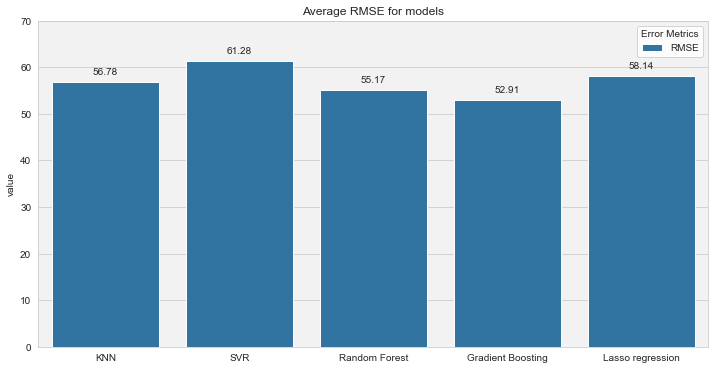

In [60]:
data = {' ': ['KNN', 'SVR', 'Random Forest','Gradient Boosting', 'Lasso regression'],
        'Error Metrics': ['RMSE', 'RMSE', 'RMSE', 'RMSE', 'RMSE'],
        'value': [56.78, 61.28, 55.17, 52.91, 58.14]}
df_scores = pd.DataFrame(data)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=" ", y="value", hue="Error Metrics", data=df_scores)
ax.set_title('Average RMSE for models')

ax.set_facecolor('#f2f2f2')
plt.ylim([0, 70])
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontsize=10)
plt.savefig('model_selection.png', dpi=300, bbox_inches='tight')

## SAVE, Test Data Preprocessing

In [61]:
X_train_selected.to_csv('preprocessed_X_train.csv',index=False)
y_train.to_csv('preprocessed_y_train.csv',index=False)
X_test_selected.to_csv('preprocessed_X_test.csv',index=False)
y_test.to_csv('preprocessed_y_test.csv',index=False)

In [62]:
#!pip install nbconvert

In [63]:
subprocess.check_call(['jupyter', 'nbconvert', '--to', 'notebook', '--execute', 'feature_patch_1.ipynb'])

[NbConvertApp] Converting notebook feature_patch_1.ipynb to notebook
[NbConvertApp] Executing notebook with kernel: python3
[NbConvertApp] Writing 3745630 bytes to feature_patch_1.nbconvert.ipynb


0

# Model tuning and fitting

Tree regression is a technique that is able to perform both regression and classification task with decision tree. Since our dataset contains many categorical variables, we choose to use the tree regressor becuase it potentially more friendly with categorical variables.

## Model Trained without average nearby listing price feature

In [67]:
X_train_1 = X_train_selected
y_train_1 = y_train

X_test_1 = pd.read_csv('preprocessed_2_X_test_1.csv', sep=',')
y_test_1 = pd.read_csv('preprocessed_2_y_test_1.csv', sep=',')

### 1. Random forest regression

In [68]:
# Define hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2', None],
}

# Define the Random Forest classifier model
rf = RandomForestRegressor()

# Use GridSearchCV to perform grid search
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# Fit the grid search to the data
grid_search.fit(X_train_1, y_train_1)

# Print the best hyperparameters and resulting accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 150}
Best accuracy score:  -53.87734402096366


In [95]:
rf = RandomForestRegressor(n_estimators = 150, max_features = 'sqrt', max_depth = 20, random_state=42)
rf.fit(X_train_1, y_train_1)
y_predict_rf = rf.predict(X_test_1)

In [96]:
importancesRF = rf.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_1.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
latitude,0.155917
longitude,0.149081
bathrooms_number,0.110037
bedrooms,0.096405
accommodates,0.093657


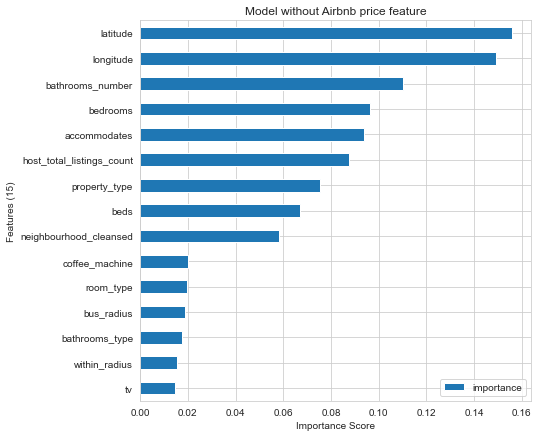

In [97]:
feat_imp = pd.DataFrame({'importance':rf.feature_importances_})  
feat_imp['feature'] = X_train_1.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
# feat_imp = feat_imp[len(feat_imp1)-15:len(feat_imp1)]
feat_imp.plot.barh(figsize=(7,7))
plt.xlabel('Importance Score')
plt.ylabel('Features (15)')
plt.title('Model without Airbnb price feature')
f = plt.gcf()
plt.show()
f.savefig("rf_importance_15.png", dpi=300, bbox_inches='tight')

In [98]:
mse = sklearn.metrics.mean_squared_error(y_test_1, y_predict_rf)  
mae_rf_1 = sklearn.metrics.mean_absolute_error(y_test_1, y_predict_rf) 

rmse_rf_1 = math.sqrt(mse)  

print("RMSE = ", rmse_rf_1)
print("MAE = ", mae_rf_1)

RMSE =  53.11092971568255
MAE =  40.16215569884392


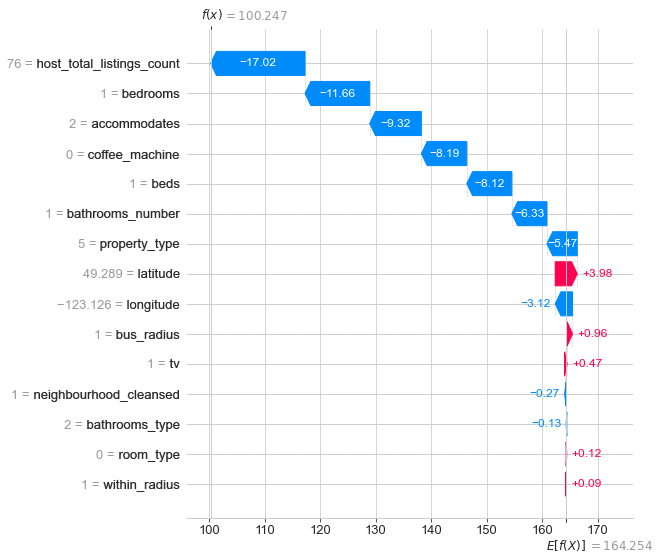

In [99]:
shap.initjs()

explainer = shap.Explainer(rf)
shap_values = explainer(X_test_1)

class helper_object():
    """
    This wraps the shap object.
    It takes as input i, which indicates the index of the observation to be explained.
    """
    def __init__(self, i):
        self.base_values = shap_values.base_values[i][0]
        self.data = X_test_1.loc[i]
        self.feature_names = X_test_1.columns.to_list()
        self.values = shap_values.values[i]
f=plt.gcf()
shap.waterfall_plot(helper_object(0), len(shap_values[0]))
f.savefig("rf_waterfall_15.png", dpi=300, bbox_inches="tight")

### 2. Gradient boosting regression

In [75]:
# Define hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.03, 0.06],
    'max_features': ['sqrt', 'log2', None],
}

# Define the Random Forest classifier model
gb = GradientBoostingRegressor()

# Use GridSearchCV to perform grid search
grid_search = GridSearchCV(
    gb, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# Fit the grid search to the data
grid_search.fit(X_train_1, y_train_1)

# Print the best hyperparameters and resulting accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Best hyperparameters:  {'learning_rate': 0.03, 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Best accuracy score:  -53.96797301074416


In [82]:
grad_boosting_tree = GradientBoostingRegressor(n_estimators=100, learning_rate = 0.03, max_features = 'log2', 
                                               max_depth = 10, random_state=42)

grad_boosting_tree.fit(X_train_1, y_train_1)
y_predict_gb = grad_boosting_tree.predict(X_test_1)

In [83]:
importancesRF = grad_boosting_tree.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_1.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
latitude,0.136956
longitude,0.131690
bathrooms_number,0.118190
accommodates,0.113860
bedrooms,0.110638


In [41]:
# feat_imp = pd.DataFrame({'importance':grad_boosting_tree.feature_importances_})  
# feat_imp['feature'] = X_train_1.columns
# feat_imp.sort_values(by='importance', ascending=False, inplace=True)

# feat_imp.sort_values(by='importance', inplace=True)
# feat_imp = feat_imp.set_index('feature', drop=True)
# feat_imp = feat_imp[len(feat_imp1)-15:len(feat_imp1)]
# feat_imp.plot.barh(figsize=(5,5))
# plt.xlabel('Importance Score')
# plt.ylabel('15 Features')
# plt.show()

In [84]:
mse = sklearn.metrics.mean_squared_error(y_test_1, y_predict_gb)  
mae_gb_1 = sklearn.metrics.mean_absolute_error(y_test_1, y_predict_gb) 

rmse_gb_1 = math.sqrt(mse)  

print("RMSE = ", rmse_gb_1)
print("MAE = ", mae_gb_1)

RMSE =  54.060334481120194
MAE =  40.776644863622295


In [139]:
# explainer = shap.TreeExplainer(grad_boosting_tree)
# shap_values = explainer.shap_values(X_test_1)

# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_1.iloc[0,:])

## Model Trained with average nearby listing price feature

In [85]:
X_test_2 = pd.read_csv('preprocessed_2_X_test_2.csv', sep=',')
y_test_2 = pd.read_csv('preprocessed_2_y_test_2.csv', sep=',')
X_train_2 = pd.read_csv('preprocessed_2_X_train.csv', sep=',')
y_train_2 = pd.read_csv('preprocessed_2_y_train.csv', sep=',')

### 1. Random forest regression

In [270]:
# Define hyperparameter grid to search over
param_grid = {
    'n_estimators': [30, 50, 100, 150, 200],
    'max_depth': [10, 20, 30, 50],
    'max_features': ['sqrt', 'log2', None],
}

# Define the Random Forest classifier model
rf = RandomForestRegressor()

# Use GridSearchCV to perform grid search
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# Fit the grid search to the data
grid_search.fit(X_train_2, y_train_2)

# Print the best hyperparameters and resulting accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Best hyperparameters:  {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 150}
Best accuracy score:  -50.46133176457067


In [86]:
rf_2 = RandomForestRegressor(n_estimators = 150, max_features = 'log2', max_depth = 10, random_state=42)
rf_2.fit(X_train_2, y_train_2)
y_predict_rf_2 = rf_2.predict(X_test_2)

In [87]:
importancesRF = rf_2.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_2.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
nearest_airbnb_price_8,0.280243
bedrooms,0.131906
bathrooms_number,0.119577
accommodates,0.080903
latitude,0.073752


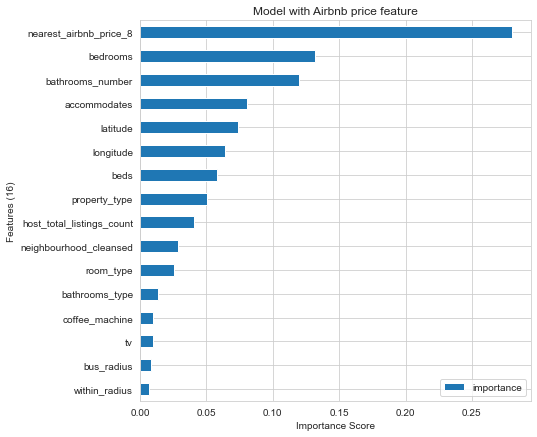

In [88]:
feat_imp = pd.DataFrame({'importance':rf_2.feature_importances_})  
feat_imp['feature'] = X_train_2.columns

feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(figsize=(7,7))
plt.xlabel('Importance Score')
plt.ylabel('Features (16)')
plt.title('Model with Airbnb price feature')
f=plt.gcf()
plt.show()
f.savefig("rf_importance_16.png", dpi=300, bbox_inches='tight')

In [89]:
mse = sklearn.metrics.mean_squared_error(y_test_2, y_predict_rf_2)  
mae_rf_2 = sklearn.metrics.mean_absolute_error(y_test_2, y_predict_rf_2) 

rmse_rf_2 = math.sqrt(mse)  

print("RMSE = ", rmse_rf_2)
print("MAE = ", mae_rf_2)

RMSE =  49.20326060194604
MAE =  31.985862045884513


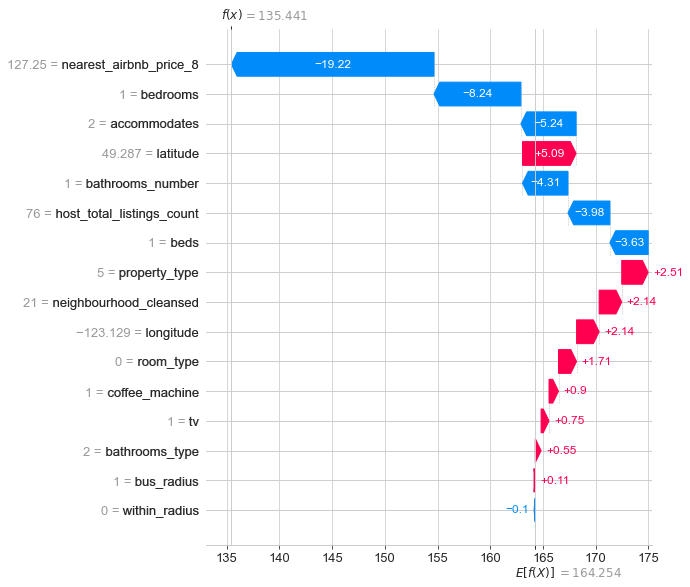

In [94]:
shap.initjs()

explainer = shap.Explainer(rf_2)
shap_values = explainer(X_test_2)

class helper_object():
    """
    This wraps the shap object.
    It takes as input i, which indicates the index of the observation to be explained.
    """
    def __init__(self, i):
        self.base_values = shap_values.base_values[i][0]
        self.data = X_test_2.loc[i]
        self.feature_names = X_test_2.columns.to_list()
        self.values = shap_values.values[i]

f=plt.gcf()
shap.waterfall_plot(helper_object(0), len(shap_values[0]))
f.savefig("rf_waterfall_16.png", dpi=300, bbox_inches="tight")

### 2. Gradient boosting regression

In [102]:
# Define hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.03, 0.06],
    'max_features': ['sqrt', 'log2', None],
}

# Define the Random Forest classifier model
gb = GradientBoostingRegressor()

# Use GridSearchCV to perform grid search
grid_search = GridSearchCV(
    gb, 
    param_grid, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

# Fit the grid search to the data
grid_search.fit(X_train_2, y_train_2)

# Print the best hyperparameters and resulting accuracy score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

Best hyperparameters:  {'learning_rate': 0.03, 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 100}
Best accuracy score:  -51.493238656942765


In [121]:
grad_boosting_tree_2 = GradientBoostingRegressor(n_estimators=100, learning_rate = 0.03, max_features = 'log2', 
                                               max_depth = 10, random_state=42)

grad_boosting_tree_2.fit(X_train_2, y_train_2)
y_predict_gb_2 = grad_boosting_tree_2.predict(X_test_2)

In [122]:
importancesRF = grad_boosting_tree_2.feature_importances_
feat_imp1 = pd.DataFrame(importancesRF, columns=['Weight'], index=X_train_2.columns)
feat_imp1.sort_values('Weight', inplace=True, ascending=False)
feat_imp1.head(5)

,Weight
nearest_airbnb_price_8,0.278599
bedrooms,0.128304
latitude,0.085738
bathrooms_number,0.085624
longitude,0.085343


In [57]:
# feat_imp = pd.DataFrame({'importance':grad_boosting_tree_2.feature_importances_})  
# feat_imp['feature'] = X_train_2.columns
# feat_imp.sort_values(by='importance', ascending=False, inplace=True)

# feat_imp.sort_values(by='importance', inplace=True)
# feat_imp = feat_imp.set_index('feature', drop=True)
# feat_imp = feat_imp[len(feat_imp1)-16:len(feat_imp1)]
# feat_imp.plot.barh(figsize=(5,5))
# plt.xlabel('Importance Score')
# plt.ylabel('16 Features')
# plt.show()

In [123]:
mse = sklearn.metrics.mean_squared_error(y_test_2, y_predict_gb_2)  
mae_gb_2 = sklearn.metrics.mean_absolute_error(y_test_2, y_predict_gb_2) 

rmse_gb_2 = math.sqrt(mse)  

print("RMSE = ", rmse_gb_2)
print("MAE = ", mae_gb_2)

RMSE =  50.550826410083936
MAE =  33.146769856607506


In [59]:
# explainer = shap.TreeExplainer(grad_boosting_tree_2)
# shap_values = explainer.shap_values(X_test_2)

# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_2.iloc[0,:])

In [117]:
df_scores

,,Error Metrics,value
0,KNN,RMSE,56.44
1,SVR,RMSE,61.30
2,Random Forest,RMSE,55.34
3,Gradient Boosting,RMSE,52.49
4,Lasso regression,RMSE,57.99


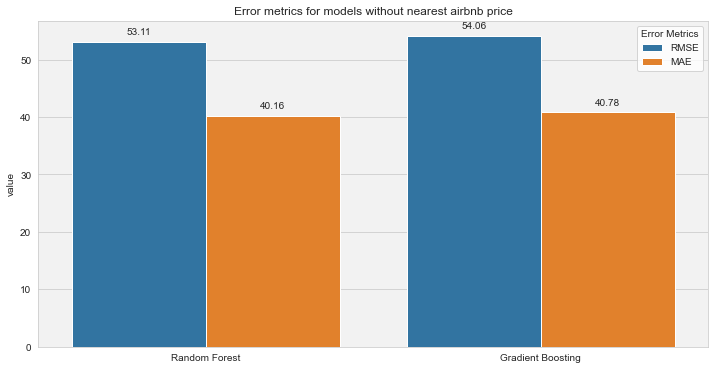

In [124]:
data = {' ': ['Random Forest', 'Random Forest','Gradient Boosting', 'Gradient Boosting'],
        'Error Metrics': ['RMSE', 'MAE', 'RMSE', 'MAE'],
        'value': [rmse_rf_1, mae_rf_1, rmse_gb_1, mae_gb_1]}
df_scores = pd.DataFrame(data)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=" ", y="value", hue="Error Metrics", data=df_scores)
ax.set_title('Error metrics for models without nearest airbnb price')

ax.set_facecolor('#f2f2f2')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontsize=10)
plt.savefig('barplot_model_1.png', dpi=300, bbox_inches='tight')

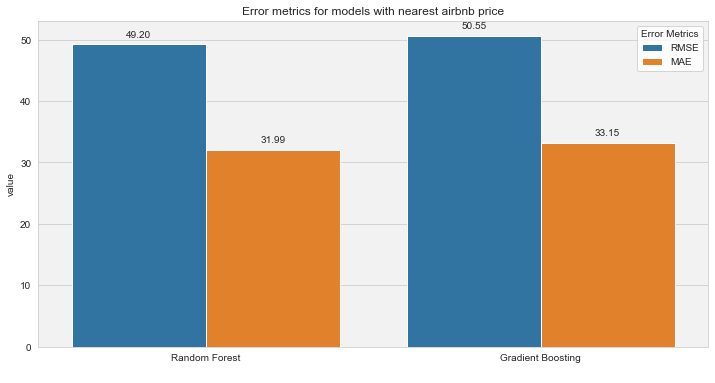

In [125]:
data = {' ': ['Random Forest', 'Random Forest', 'Gradient Boosting', 'Gradient Boosting'],
        'Error Metrics': ['RMSE', 'MAE', 'RMSE', 'MAE'],
        'value': [rmse_rf_2, mae_rf_2, rmse_gb_2, mae_gb_2]}
df_scores = pd.DataFrame(data)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=" ", y="value", hue="Error Metrics", data=df_scores)
ax.set_title('Error metrics for models with nearest airbnb price')

ax.set_facecolor('#f2f2f2')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points', fontsize=10)
plt.savefig('barplot_model_2.png', dpi=300, bbox_inches='tight')

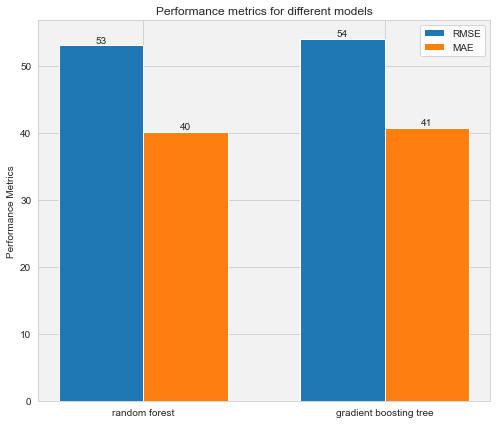

In [126]:
import numpy as np
# Define the labels for each variable and group
labels = ['random forest', 'gradient boosting tree']
rmse_values = [rmse_rf_1, rmse_gb_1]
mae_values = [mae_rf_1, mae_gb_1]

x = np.arange(len(labels))
width = 0.35

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(7,6))

# Create the bars for RMSE and MAE
rects1 = ax.bar(x - width/2, rmse_values, width, label='RMSE')
rects2 = ax.bar(x + width/2, mae_values, width, label='MAE')

# Add labels, title, and legend to the plot
ax.set_ylabel('Performance Metrics')
ax.set_title('Performance metrics for different models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_facecolor('#f2f2f2')
for rect in rects1 + rects2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

### Random Forest

Random Forest is an emsemble technique that is able to perform Regression tasks with the use of multiple decision trees and a technique that is called Bootstrap aggregation (Bagging). The idea behind this technique is to combine multiple results of decision trees in its prediction rather than replying on individual decision trees, thus reduces the variance.

Importance provides a score that indicates how useful or important each feature was in the construction of the decision trees within the model. The higher its relative importance, the more a variable is used to make key decisions within decision trees.

Therefore, feature importance can be used to interpret our data to understand the most important features that define our predictions. In this case, looking at the bar chart above, the predictor variable that is associated with a longer bar means that the variable has a higher importance in the Random Tree Regression Model in predicting price.